#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

iris = load_iris()

x = iris.data
y = iris.target
TEST = 0.9

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST)

In [ ]:
def entropy_func(class_count, num_samples):
    entropy = 0
    for count in class_count.values():
        prop = count / num_samples
        if prop > 0:
            entropy -= prop * math.log2(prop)
    return entropy


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return sum(self.group_classes.values())

    def group_entropy(self):
        return entropy_func(self.group_classes, len(self))


class Node:
    def __init__(self, split_feature, split_val, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data):
        if self.val is not None:
            return self.val
        
        if data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)

class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a, group_b):
        allSamples = len(group_a) + len(group_b)
        return (len(group_a)/allSamples * group_a.entropy) +  (len(group_b)/allSamples * group_b.entropy)

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        return parent_group.entropy - self.get_split_entropy(child_group_a, child_group_b)

    def get_best_feature_split(self, feature_values, classes):
        unique_values = np.unique(feature_values)
        pot_splits = (unique_values[:-1] + unique_values[1:]) / 2
        best_inf_gain = -np.inf
        best_split_val = None

        parent = Group(Counter(classes))

        for split_val in pot_splits:
            mask_a = feature_values <= split_val
            mask_b = feature_values > split_val

            a_classes = classes[mask_a]
            b_classes = classes[mask_b]
            if(len(a_classes) == 0 or len(b_classes) == 0):
                continue
            
            group_a = Group(Counter(a_classes))
            group_b = Group(Counter(b_classes))

            inf_gain = self.get_information_gain(parent, group_a, group_b)

            if(inf_gain > best_inf_gain):
                best_inf_gain = inf_gain
                best_split_val = split_val
        split = np.array([0, best_split_val, best_inf_gain])
        return split
        
    def get_best_split(self, data, classes):
        split = np.zeros(3) #split feature, split value, information gain

        for col in range(data.shape[1]):
            values = data[:, col]
            temp_split = np.copy(self.get_best_feature_split(values, classes))
            if(temp_split[2] > split[2]):
                split = np.copy(temp_split)
                split[0] = col
        return split

    def build_tree(self, data, classes, depth=0):
        parent_entropy = entropy_func(Counter(classes), len(classes))
        if(parent_entropy == 0 or depth >= self.max_depth or len(classes) == 0):
            if(len(classes) != 0):
                leaf_class = Counter(classes).most_common(1)[0][0]
            else:
                leaf_class = None
            return Node(None, None, depth, None, None, leaf_class)
        
        split = np.copy(self.get_best_split(data, classes))
        split_feat = int(split[0])

        mask_a = data[:, split_feat] <= split[1]
        mask_b = data[:, split_feat] > split[1]
        group_a_data = data[mask_a]
        group_a_classes = classes[mask_a]
        group_b_data = data[mask_b]
        group_b_classes = classes[mask_b]

        child_node_a = self.build_tree(group_a_data, group_a_classes, depth + 1)
        child_node_b = self.build_tree(group_b_data, group_b_classes, depth + 1)
        return Node(split_feat, split[1], depth, child_node_a, child_node_b, None)
    
    def fit(self, data, classes):
        self.tree = self.build_tree(data, classes)

    def predict(self, data):
        return self.tree.predict(data)

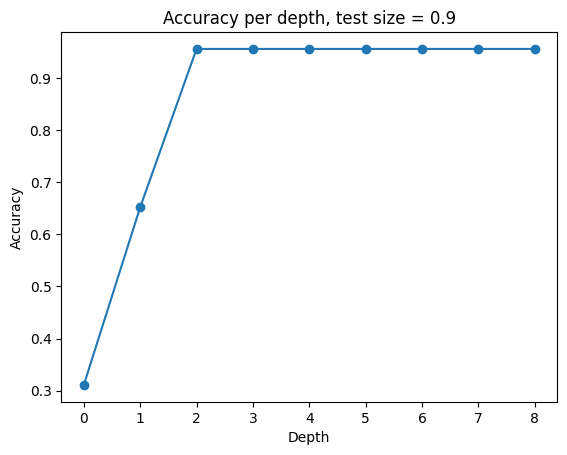

In [ ]:
max_depth = 9
accuracy = np.empty(max_depth)
depth_list = np.empty(max_depth)

for depth in range(max_depth):
    depth_list[depth] = depth
    dc = DecisionTreeClassifier(depth)
    dc.fit(x_train, y_train)
    correct_predictions = 0
    for sample, gt in zip(x_test, y_test):
        prediction = dc.predict(sample)
        if prediction == gt:
            correct_predictions+=1
        #print(f"Prediction = {prediction}; Real value = {gt}")
    accuracy[depth] = correct_predictions/len(y_test)
    #print(f"Accuracy = {accuracy[depth]}\n")

plt.plot(depth_list, accuracy, marker='o')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title(f"Accuracy per depth, test size = {TEST}")
plt.show()

Wyniki dla podanych na samym początku danych (random_state = 123)

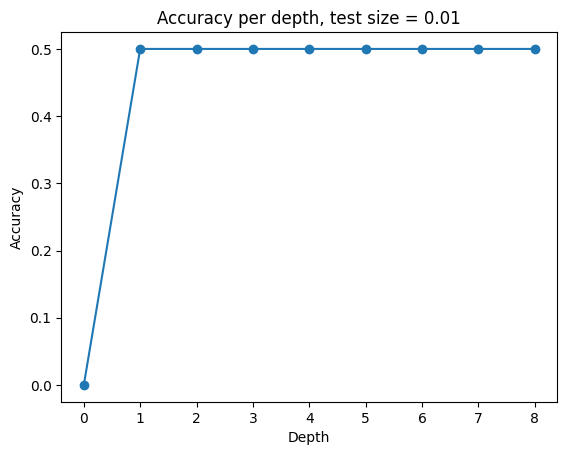
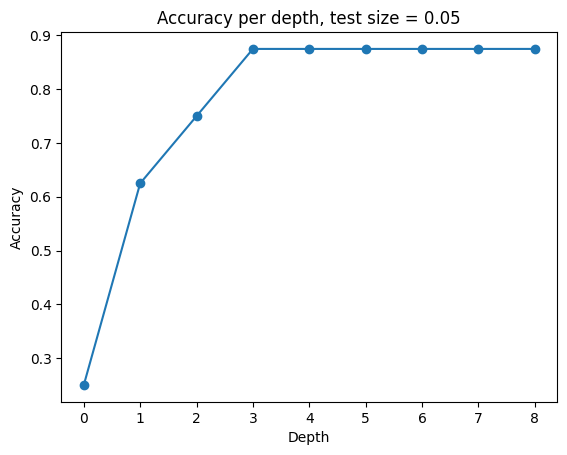
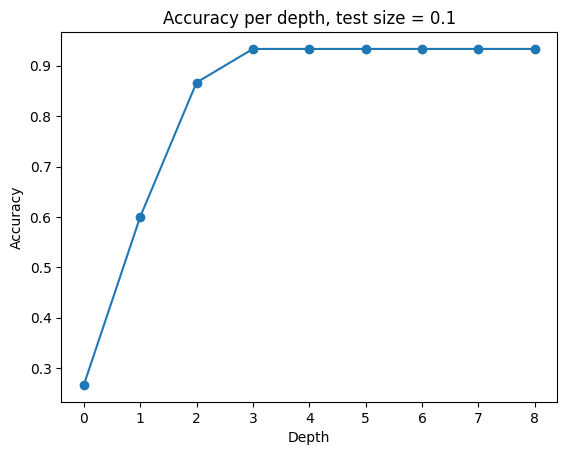
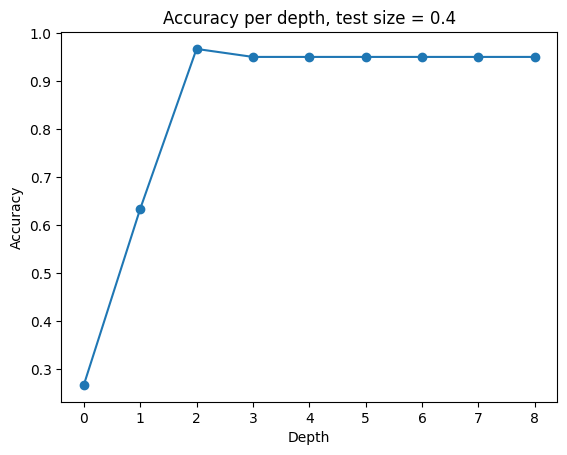
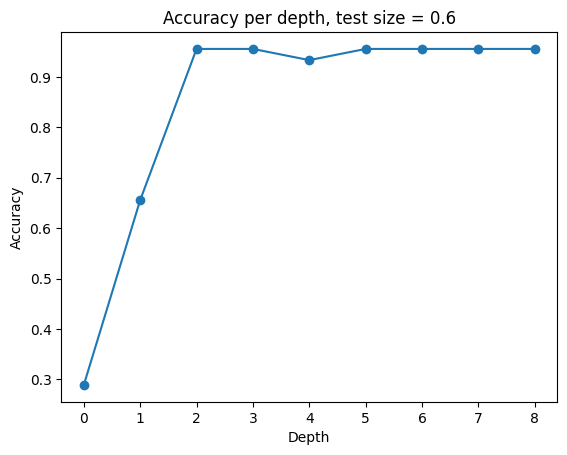
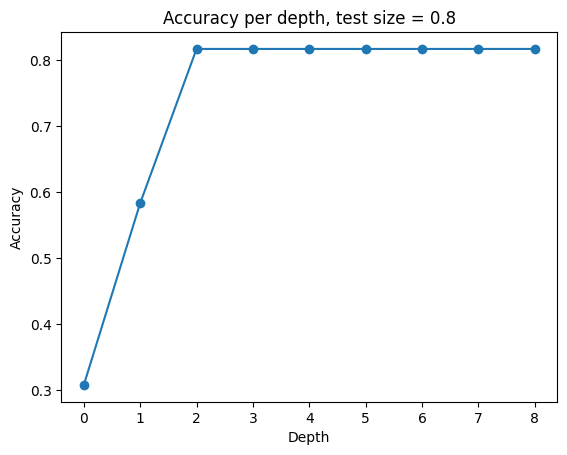
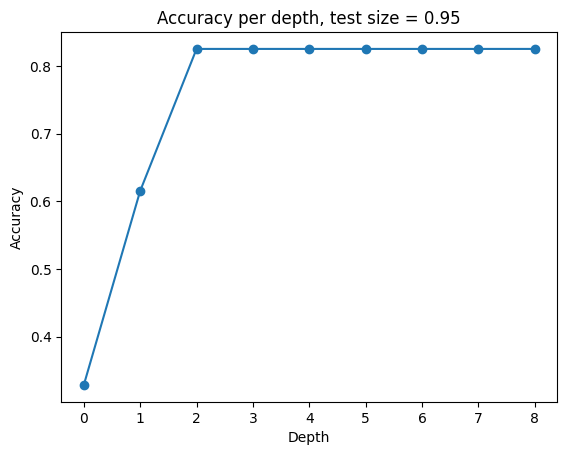

Inne eksperymenty, na ciągle zmieniających się danych
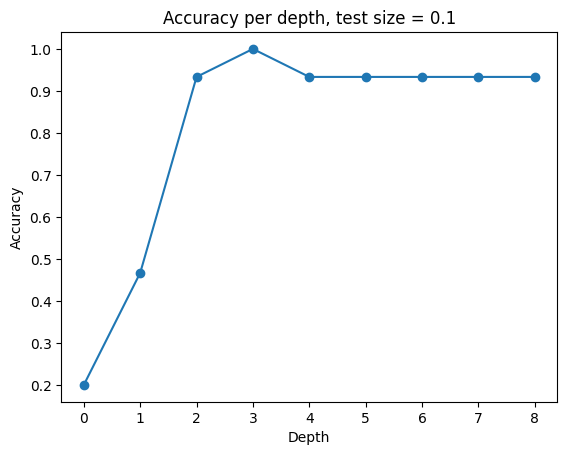
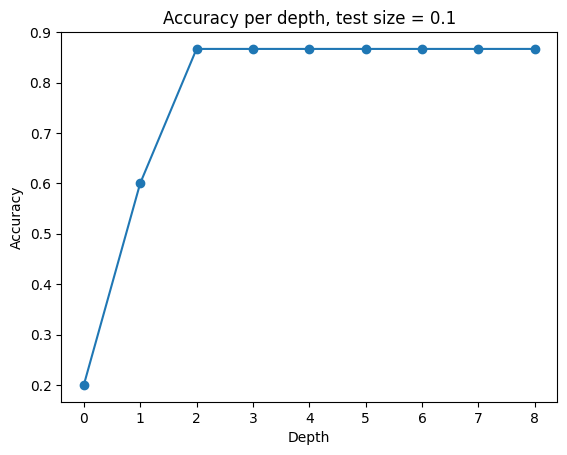
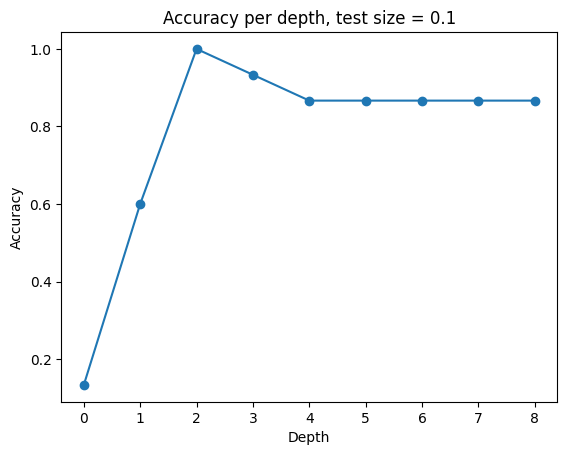
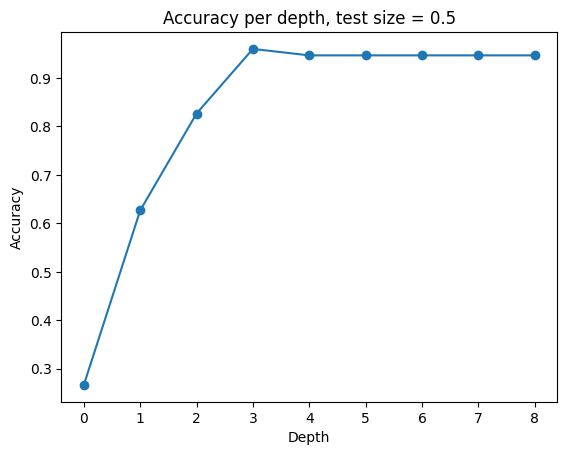
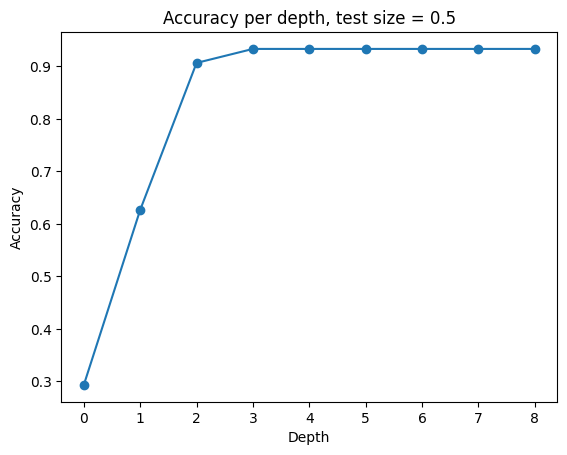
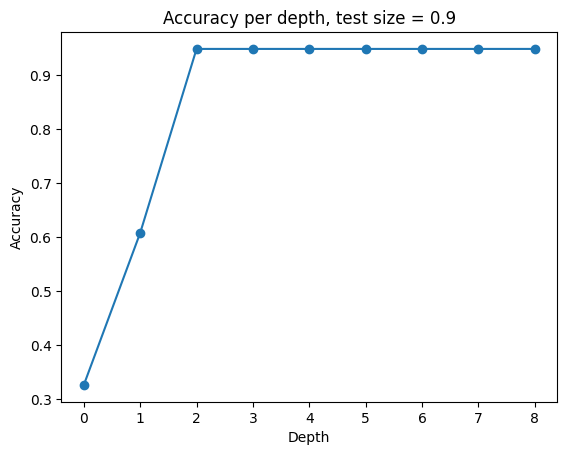
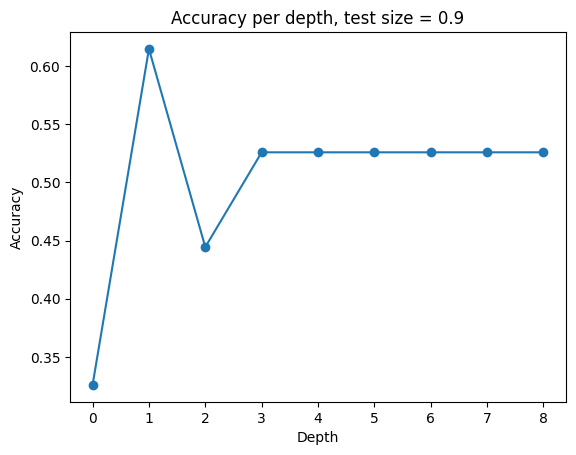
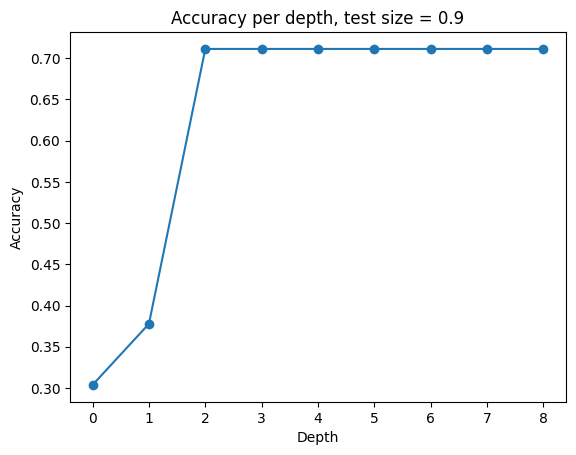
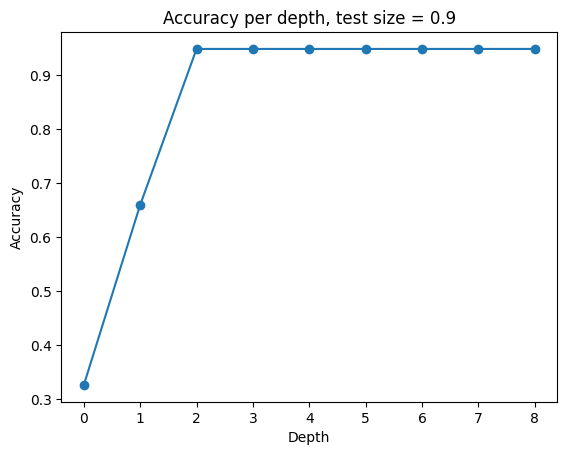